In [1]:
%load_ext watermark


In [2]:
import numpy as np
import pandas as pd
from scipy import stats as scipy_stats
import seaborn as sns
from teeplot import teeplot as tp
from tqdm import tqdm

from pylib._seed_global_rngs import seed_global_rngs
from pylib._summarize_sequence_diffs import summarize_sequence_diffs


Covasim 3.1.6 (2024-01-28) — © 2020-2024 by IDM


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-05-15T15:25:25.134858+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1027-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

numpy  : 2.1.2
pandas : 2.2.3
scipy  : 1.14.1
teeplot: 1.4.2
seaborn: 0.13.2

Watermark: 2.4.3



In [4]:
teeplot_subdir = "2025-04-30-profile-mut-freqs"
teeplot_subdir


'2025-04-30-profile-mut-freqs'

In [5]:
seed_global_rngs(1)


## Get Data


In [6]:
df = pd.read_parquet("https://osf.io/2guwm/download")


In [7]:
df["replicate_uuid"].nunique()


60

In [8]:
len_ancestor = df["ancestral_sequence"].str.len().unique().item()


In [9]:
records = []
for uuid, grp in tqdm(df.groupby("replicate_uuid", observed=True)):
    grp = grp.reset_index(drop=True).copy()
    (unique_mutations, counts, columns,) = summarize_sequence_diffs(
        sequence_diffs=grp["sequence_diff"],
    )
    record = {
        "replicate_uuid": uuid,
        "trt_name": grp["trt_name"].unique().astype(str).item(),
    }
    has_focal_mutation = int(unique_mutations[0] >> 8 == 0)
    records.append(
        {
            **record,
            "mutation": "focal",
            "count": counts[0] if has_focal_mutation else 0,
        }
    )
    possible_counts = len_ancestor * 3
    extended_counts = np.zeros(possible_counts, dtype=int)
    extended_counts[: len(counts) - has_focal_mutation] = counts[
        has_focal_mutation:
    ]
    for count in np.random.choice(extended_counts, 1_000):
        records.append(
            {
                **record,
                "mutation": "non-focal",
                "count": count,
            }
        )


  3%|▎         | 2/60 [00:05<02:06,  2.18s/it]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.028755664825439453}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003941059112548828}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0012862682342529297}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0007035732269287109}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.018337249755859375}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.00028967857360839844}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.00041556358337402344}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006678104400634766}


  7%|▋         | 4/60 [00:05<00:45,  1.22it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.018315553665161133}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0002875328063964844}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0003757476806640625}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006661415100097656}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.018503904342651367}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.00030875205993652344}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.00044274330139160156}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006146430969238281}


 10%|█         | 6/60 [00:05<00:23,  2.30it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.01813197135925293}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0002980232238769531}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.00039076805114746094}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006535053253173828}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.018343687057495117}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003094673156738281}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0003752708435058594}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006418228149414062}


 13%|█▎        | 8/60 [00:06<00:15,  3.32it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.018489837646484375}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.000286102294921875}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.00041413307189941406}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006299018859863281}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.019019365310668945}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003590583801269531}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0005369186401367188}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006401538848876953}


 17%|█▋        | 10/60 [00:06<00:11,  4.35it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.018471956253051758}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.00030994415283203125}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.00043129920959472656}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006272792816162109}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.018741130828857422}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.00037670135498046875}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0005257129669189453}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006642341613769531}

 20%|██        | 12/60 [00:06<00:09,  5.16it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.01949024200439453}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.00032973289489746094}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0005345344543457031}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006265640258789062}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.018151521682739258}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.00030040740966796875}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.00044846534729003906}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.000606536865234375}


 23%|██▎       | 14/60 [00:07<00:08,  5.54it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.018549203872680664}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.00033783912658691406}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0004355907440185547}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006513595581054688}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.018715381622314453}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003478527069091797}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0005245208740234375}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006802082061767578}


 27%|██▋       | 16/60 [00:07<00:07,  5.96it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.018393754959106445}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003185272216796875}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0004291534423828125}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006740093231201172}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.018692493438720703}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003380775451660156}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0004467964172363281}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006487369537353516}


 30%|███       | 18/60 [00:07<00:06,  6.06it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.0187685489654541}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003066062927246094}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0004718303680419922}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006477832794189453}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.018527984619140625}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.00031948089599609375}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0004811286926269531}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.000614166259765625}


 32%|███▏      | 19/60 [00:08<00:06,  6.20it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.018280744552612305}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0002911090850830078}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.00036787986755371094}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006232261657714844}


 35%|███▌      | 21/60 [00:08<00:06,  5.71it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.018914222717285156}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003235340118408203}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0005078315734863281}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006132125854492188}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.01863574981689453}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003113746643066406}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0004992485046386719}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006299018859863281}


 38%|███▊      | 23/60 [00:08<00:06,  5.83it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.01880025863647461}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.00032401084899902344}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0004444122314453125}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006575584411621094}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.01897740364074707}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003333091735839844}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0004432201385498047}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006945133209228516}


 42%|████▏     | 25/60 [00:09<00:05,  6.07it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.01892852783203125}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003211498260498047}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0005209445953369141}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0007150173187255859}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.018411636352539062}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.00031447410583496094}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0004642009735107422}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006413459777832031}


 43%|████▎     | 26/60 [00:09<00:05,  6.04it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.01871657371520996}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.00028824806213378906}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0003769397735595703}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006639957427978516}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.0183563232421875}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.00032401084899902344}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.00046181678771972656}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006606578826904297}


 48%|████▊     | 29/60 [00:09<00:05,  6.01it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.018679380416870117}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003788471221923828}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0005161762237548828}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006487369537353516}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.018635034561157227}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.00034737586975097656}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.00044536590576171875}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006489753723144531}


 52%|█████▏    | 31/60 [00:10<00:04,  6.04it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.019075870513916016}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.00035691261291503906}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0004909038543701172}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006542205810546875}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.018822908401489258}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.00036597251892089844}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0005443096160888672}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006334781646728516}


 53%|█████▎    | 32/60 [00:10<00:04,  5.73it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.05869770050048828}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.00033974647521972656}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.00047135353088378906}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006215572357177734}


 57%|█████▋    | 34/60 [00:10<00:04,  6.03it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.01853203773498535}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.000301361083984375}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.00045037269592285156}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006453990936279297}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.01835942268371582}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.00028133392333984375}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.00038433074951171875}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006325244903564453}


 60%|██████    | 36/60 [00:10<00:03,  6.07it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.019398927688598633}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003910064697265625}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0005738735198974609}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006556510925292969}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.01854109764099121}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.00031065940856933594}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0003933906555175781}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006985664367675781}


 63%|██████▎   | 38/60 [00:11<00:03,  6.21it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.01847982406616211}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003180503845214844}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0004534721374511719}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006368160247802734}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.01889348030090332}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003542900085449219}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0004563331604003906}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006542205810546875}


 67%|██████▋   | 40/60 [00:11<00:03,  5.79it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.0183255672454834}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003142356872558594}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0003807544708251953}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006716251373291016}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.018619537353515625}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.00034236907958984375}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0004894733428955078}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006706714630126953}


 70%|███████   | 42/60 [00:11<00:03,  5.90it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.019113779067993164}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003402233123779297}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0004992485046386719}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006628036499023438}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.019272804260253906}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003428459167480469}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0004985332489013672}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006692409515380859}


 73%|███████▎  | 44/60 [00:12<00:02,  6.10it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.01861882209777832}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003275871276855469}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0005171298980712891}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006425380706787109}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.01847982406616211}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.00036644935607910156}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0005228519439697266}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006160736083984375}


 75%|███████▌  | 45/60 [00:12<00:02,  6.10it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.02221822738647461}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003304481506347656}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0005409717559814453}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0007910728454589844}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.018541812896728516}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003139972686767578}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.00046324729919433594}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006783008575439453}


 80%|████████  | 48/60 [00:12<00:01,  6.07it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.01877903938293457}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.000335693359375}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.000499725341796875}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006687641143798828}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.01849985122680664}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003497600555419922}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.00044345855712890625}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006384849548339844}


 83%|████████▎ | 50/60 [00:13<00:01,  6.06it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.018631696701049805}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003364086151123047}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0004527568817138672}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006511211395263672}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.01928853988647461}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0004069805145263672}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0005640983581542969}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006585121154785156}


 85%|████████▌ | 51/60 [00:13<00:01,  6.19it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.018616199493408203}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.00034809112548828125}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0004813671112060547}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006544589996337891}


 88%|████████▊ | 53/60 [00:13<00:01,  5.86it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.017807960510253906}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0002853870391845703}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0003643035888671875}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006301403045654297}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.019169092178344727}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003485679626464844}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0005316734313964844}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006406307220458984}


 92%|█████████▏| 55/60 [00:14<00:00,  6.12it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.01900792121887207}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.00033855438232421875}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0005280971527099609}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006940364837646484}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.0185699462890625}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003662109375}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0004680156707763672}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0007085800170898438}


 95%|█████████▌| 57/60 [00:14<00:00,  6.17it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.01872420310974121}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003025531768798828}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.00037217140197753906}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006585121154785156}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.018636226654052734}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003342628479003906}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.00047206878662109375}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006670951843261719}


 98%|█████████▊| 59/60 [00:14<00:00,  6.25it/s]

enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.019136428833007812}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003345012664794922}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0004839897155761719}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0007083415985107422}
enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.01832890510559082}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.0003147125244140625}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0003800392150878906}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006759166717529297}


100%|██████████| 60/60 [00:14<00:00,  4.03it/s]


enter log_context_duration for seq_diff_rows
exit log_context_duration for seq_diff_rows
!!! {"seq_diff_rows": 0.018628358840942383}
enter log_context_duration for coo_matrix
exit log_context_duration for coo_matrix
!!! {"coo_matrix": 0.00036787986755371094}
enter log_context_duration for coo.tocsc
exit log_context_duration for coo.tocsc
!!! {"coo.tocsc": 0.0005190372467041016}
enter log_context_duration for np.split
exit log_context_duration for np.split
!!! {"np.split": 0.0006608963012695312}


In [10]:
data = pd.DataFrame(records)
data["count1"] = data["count"] + 1


In [11]:
for trt, grp in data.groupby("trt_name"):
    res = scipy_stats.mannwhitneyu(
        grp.loc[grp["mutation"] == "focal", "count"],
        grp.loc[grp["mutation"] == "non-focal", "count"],
    )
    print(trt, res)


Sben/Gdel MannwhitneyuResult(statistic=399938.0, pvalue=7.409612298008289e-16)
Sben/Gneu MannwhitneyuResult(statistic=399928.0, pvalue=6.826029377673738e-16)
Sneu/Gneu MannwhitneyuResult(statistic=151626.5, pvalue=0.0509624002509033)


teeplots/2025-04-30-profile-mut-freqs/col=trt-name+element=poly+hue=mutation+ls=+stat=density+viz=displot+x=count1+ext=.pdf
teeplots/2025-04-30-profile-mut-freqs/col=trt-name+element=poly+hue=mutation+ls=+stat=density+viz=displot+x=count1+ext=.png


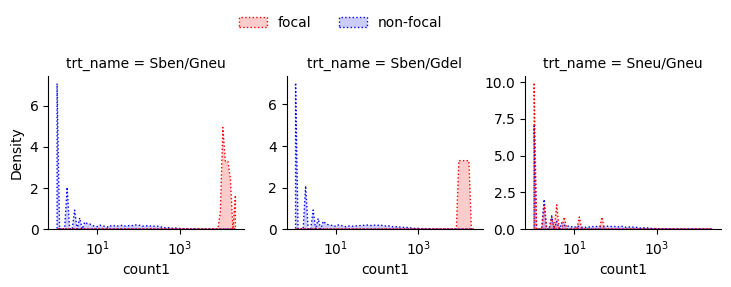

In [12]:
with tp.teed(
    sns.displot,
    data=data,
    x="count1",
    hue="mutation",
    col="trt_name",
    element="poly",
    # kind="kde",
    fill=True,
    common_norm=False,
    stat="density",
    alpha=0.2,
    palette=["#FF0000", "#0000FF"],
    log_scale=True,
    height=2.5,
    ls=":",
    facet_kws=dict(
        sharex=False,
        sharey=False,
    ),
    teeplot_subdir=teeplot_subdir,
) as teed:
    sns.move_legend(
        teed,
        "lower center",
        bbox_to_anchor=(0.4, 1),
        ncol=2,
        title=None,
        frameon=False,
    )


In [13]:
for mut, grp in data.groupby("mutation"):
    res = scipy_stats.mannwhitneyu(
        grp.loc[grp["trt_name"] == "Sben/Gneu", "count"],
        grp.loc[grp["trt_name"] == "Sben/Gdel", "count"],
    )
    print(mut, res)


focal MannwhitneyuResult(statistic=222.0, pvalue=0.5608516966002302)
non-focal MannwhitneyuResult(statistic=199332369.0, pvalue=0.546605882350617)


teeplots/2025-04-30-profile-mut-freqs/col=mutation+hue=trt-name+kind=kde+ls=+viz=displot+x=count1+ext=.pdf
teeplots/2025-04-30-profile-mut-freqs/col=mutation+hue=trt-name+kind=kde+ls=+viz=displot+x=count1+ext=.png


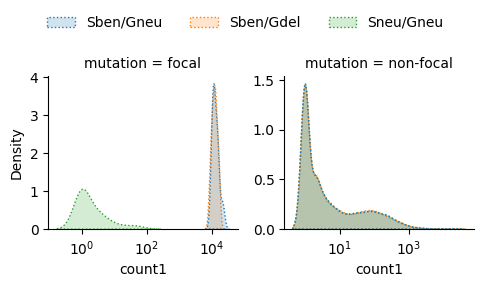

In [14]:
with tp.teed(
    sns.displot,
    data=data,
    x="count1",
    col="mutation",
    hue="trt_name",
    kind="kde",
    fill=True,
    common_norm=False,
    alpha=0.2,
    log_scale=True,
    height=2.5,
    ls=":",
    facet_kws=dict(
        sharex=False,
        sharey=False,
    ),
    teeplot_subdir=teeplot_subdir,
) as teed:
    sns.move_legend(
        teed,
        "lower center",
        bbox_to_anchor=(0.4, 1),
        ncol=3,
        title=None,
        frameon=False,
    )


teeplots/2025-04-30-profile-mut-freqs/col=mutation+excl=Sneu-Gneu+hue=trt-name+kind=kde+ls=+viz=displot+x=count1+ext=.pdf
teeplots/2025-04-30-profile-mut-freqs/col=mutation+excl=Sneu-Gneu+hue=trt-name+kind=kde+ls=+viz=displot+x=count1+ext=.png


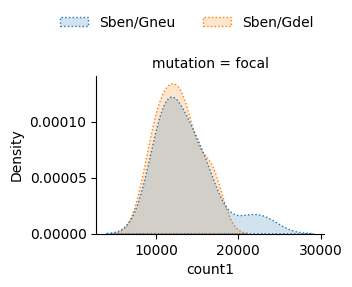

In [15]:
with tp.teed(
    sns.displot,
    data=data[
        (data["trt_name"] != "Sneu/Gneu") & (data["mutation"] == "focal")
    ],
    x="count1",
    col="mutation",
    hue="trt_name",
    kind="kde",
    fill=True,
    common_norm=False,
    alpha=0.2,
    height=2.5,
    aspect=1.5,
    ls=":",
    facet_kws=dict(
        sharex=False,
        sharey=False,
    ),
    teeplot_outattrs={"excl": "Sneu-Gneu"},
    teeplot_subdir=teeplot_subdir,
) as teed:
    sns.move_legend(
        teed,
        "lower center",
        bbox_to_anchor=(0.4, 1),
        ncol=2,
        title=None,
        frameon=False,
    )
